In [12]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import scipy

import sys
sys.path.append('../../..')
import mutagenesisfunctions as mf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

from Bio import AlignIO
import time as time
import pandas as pd
%matplotlib inline

Data extraction and dict construction completed in: 0.26s
loading model from:  ../../results/toyhp/mlp_med_best.ckpt
INFO:tensorflow:Restoring parameters from ../../results/toyhp/mlp_med_best.ckpt
  test  loss:		0.00379
  test  accuracy:	0.99997+/-0.00000
  test  auc-roc:	1.00000+/-0.00000
  test  auc-pr:		1.00000+/-0.00000
loading model from:  ../../results/toyhp/mlp_med_best.ckpt
INFO:tensorflow:Restoring parameters from ../../results/toyhp/mlp_med_best.ckpt
0
Epoch duration =13.52s
Cumulative duration =0.14s

100
Epoch duration =13.19s
Cumulative duration =13.52s

200
Epoch duration =13.48s
Cumulative duration =26.81s

300
Epoch duration =13.41s
Cumulative duration =40.06s

400
Epoch duration =13.14s
Cumulative duration =53.35s

----------------Summing complete----------------
Saving scores to toyhp_mlpmed_so0k.npy


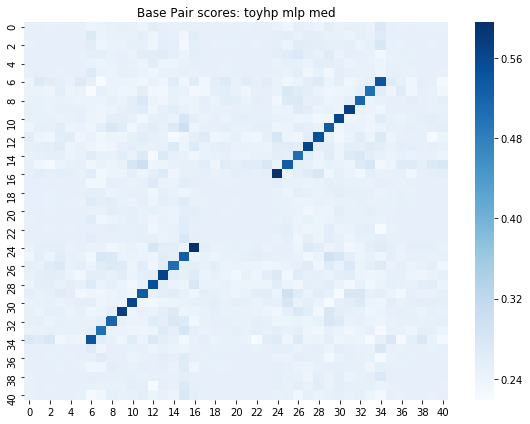

In [35]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import scipy

import sys
sys.path.append('../../..')
import mutagenesisfunctions as mf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

from Bio import AlignIO
import time as time
import pandas as pd
#---------------------------------------------------------------------------------------------------------------------------------
'''DEFINE ACTIONS'''
TEST = True
WRITE = False
FOM = False
SOMCALC = True
SOMVIS = True

if '--test' in sys.argv:
  TEST = True
if '--write' in sys.argv:
  WRITE = True
if '--fom' in sys.argv:
  FOM = True
if '--somcalc' in sys.argv:
  SOMCALC = True
if '--somvis' in sys.argv:
  SOMVIS = True

#---------------------------------------------------------------------------------------------------------------------------------
'''DEFINE LOOP'''
trials = ['small', 'med', 'large']
exp = 'toyhp'  #for both the data folder and the params folder
exp_data = 'data_%s'%(exp)

img_folder = 'Images'

for t in ['med']:


  #---------------------------------------------------------------------------------------------------------------------------------

  '''OPEN DATA'''

  starttime = time.time()

  #Open data from h5py
  filename = '%s_50k_%s.hdf5'%(exp, t)
  data_path = os.path.join('../..', exp_data, filename)
  with h5py.File(data_path, 'r') as dataset:
      X_data = np.array(dataset['X_data'])
      Y_data = np.array(dataset['Y_data'])
      
  numdata, seqlen, dims = X_data.shape
  X_data = np.expand_dims(X_data, axis=2)
      
  # get validation and test set from training set
  test_frac = 0.3
  valid_frac = 0.1
  N = numdata
  split_1 = int(N*(1-valid_frac-test_frac))
  split_2 = int(N*(1-test_frac))
  shuffle = np.random.permutation(N)

  #set up dictionaries
  train = {'inputs': X_data[shuffle[:split_1]], 
           'targets': Y_data[shuffle[:split_1]]}
  valid = {'inputs': X_data[shuffle[split_1:split_2]], 
           'targets': Y_data[shuffle[split_1:split_2]]}
  test = {'inputs': X_data[shuffle[split_2:]], 
           'targets': Y_data[shuffle[split_2:]]}
      
  print ('Data extraction and dict construction completed in: ' + mf.sectotime(time.time() - starttime))


  #---------------------------------------------------------------------------------------------------------------------------------


  '''SAVE PATHS AND PARAMETERS'''
  params_results = '../../results'

  modelarch = 'mlp'
  trial = t
  modelsavename = '%s_%s'%(modelarch, trial)



  '''BUILD NEURAL NETWORK'''

  def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    
    layer2 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                        # concat, embedding, variational_normal, variational_softmax, + more
              'num_units': 44,
              'norm': 'batch',          # if removed, automatically adds bias instead
              'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
              'dropout': 0.5,           # if removed, default is no dropout
             }
    
    layer3 = {'layer': 'dense',
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    model_layers = [layer1, layer2, layer3]

    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "l2": 1e-5,
                  #"label_smoothing": 0.05,
                  #"l1": 1e-6,
                  }
    return model_layers, optimization

  tf.reset_default_graph()

  # get shapes of inputs and targets
  input_shape = list(train['inputs'].shape)
  input_shape[0] = None
  output_shape = train['targets'].shape

  # load model parameters
  model_layers, optimization = cnn_model(input_shape, output_shape)

  # build neural network class
  nnmodel = nn.NeuralNet(seed=247)
  nnmodel.build_layers(model_layers, optimization)

  # compile neural trainer
  save_path = os.path.join(params_results, exp)
  param_path = os.path.join(save_path, modelsavename)
  nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

  sess = utils.initialize_session()
  '''TEST'''
  if TEST:
    
    # set best parameters
    nntrainer.set_best_parameters(sess)

    # test model
    loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

    if WRITE:
      metricsline = '%s,%s,%s,%s,%s,%s,%s'%(exp, modelarch, trial, loss, mean_vals[0], mean_vals[1], mean_vals[2])
      fd = open('test_metrics.csv', 'a')
      fd.write(metricsline+'\n')
      fd.close()
  '''SORT ACTIVATIONS'''
  nntrainer.set_best_parameters(sess)
  predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
  plot_index = np.argsort(predictionsoutput[:,0])[::-1]

  #---------------------------------------------------------------------------------------------------------------------------------
  '''FIRST ORDER MUTAGENESIS'''
  if FOM:
    num_plots = range(1)
    for ii in num_plots: 

        X = np.expand_dims(test['inputs'][plot_index[10000+ii]], axis=0)
        
        mf.fom_saliency(X, layer='dense_1_bias', alphabet='rna', nntrainer=nntrainer, sess=sess, figsize=(15,1.5))
        fom_file = modelsavename + 'FoM' + '.png'
        fom_file = os.path.join(img_folder, fom_file)
        plt.savefig(fom_file)

    plt.close()
  #---------------------------------------------------------------------------------------------------------------------------------
  '''SECOND ORDER MUTAGENESIS'''

  '''Som calc'''
  if SOMCALC:
    num_summary = 500

    arrayspath = '%s_%s%s_so%.0fk.npy'%(exp, modelarch, trial, num_summary/1000)
    X = test['inputs'][plot_index[:num_summary]]

    mean_mut2 = mf.som_average_ungapped(X, range(seqlen), arrayspath, nntrainer, sess, progress='short', 
                                            normalize = False, save=True, layer='dense_1_bias')

  if SOMVIS:  
    #Load the saved data
    num_summary = 500
    arrayspath = '%s_%s%s_so%.0fk.npy'%(exp, modelarch, trial, num_summary/1000)
    mean_mut2 = np.load(arrayspath)

    #Reshape into a holistic tensor organizing the mutations into 4*4
    meanhol_mut2 = mean_mut2.reshape(seqlen,seqlen,4,4)

    #Normalize
    normalize = True
    if normalize:
        norm_meanhol_mut2 = mf.normalize_mut_hol(meanhol_mut2, nntrainer, sess, normfactor=1)

    #Let's try something weird
    bpfilter = np.ones((4,4))*0.
    for i,j in zip(range(4), range(4)):
        bpfilter[i, -(j+1)] = +1.

    nofilter = np.ones((4,4))

    C = (norm_meanhol_mut2*bpfilter)
    C = np.sum((C).reshape(seqlen,seqlen,dims*dims), axis=2)
    #C = C - np.mean(C)
    #C = C/np.max(C)

    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    sb.heatmap(C,vmin=None, cmap='Blues', linewidth=0.0)
    plt.title('Base Pair scores: %s %s %s'%(exp, modelarch, trial))
    plt.show()



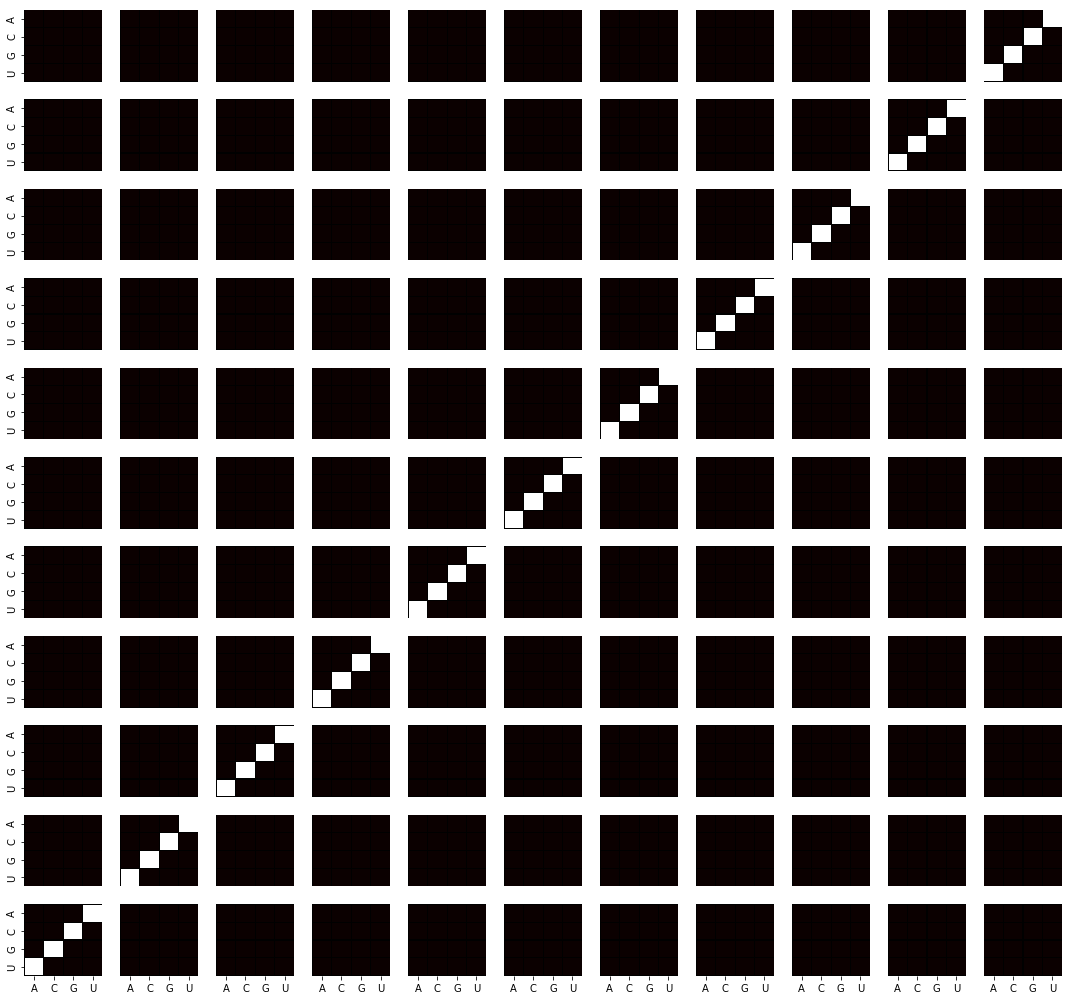

In [40]:
mf.square_holplot(meanhol_mut2, 11, 'rna', limits=(4.,6.), title=False, cmap ='hot',
                   figsize=(15,14), lines=True, start=(6,24), reverse=False, cbar=False)

In [36]:
meanhol_mut2[6,34]

array([[ 1.6614125, -1.7233807, -3.5923262,  6.483739 ],
       [-2.934809 , -2.2507265,  6.7658935, -3.2428176],
       [-4.0609665,  6.8785844, -2.7235153, -3.2663493],
       [ 6.7451434, -4.0075417, -3.3293006,  1.8740425]], dtype=float32)

In [30]:
np.exp(-0.25)

0.7788007830714049